In [1]:
using Pkg
#Pkg.develop("QuantumDots")
Pkg.activate(pwd())
Pkg.instantiate()
using QuantumDots, Plots, LinearAlgebra, OrdinaryDiffEqTsit5, SteadyStateDiffEq

  Activating project at `c:\Users\svens\Projects\QuantumDots.jl\examples`


In [2]:
Q = QubitBasis(1)
H(t) = Q[1, :X] * exp(-sin(t)^2) + Q[1, :Z]
L = Q[1, :Z]
dρ(ρ, γ, t) = -1im * (H(t) * ρ - ρ * H(t)) + γ * (L * ρ * L' - 1 / 2 * (L'L * ρ + ρ * L'L))

dρ (generic function with 1 method)

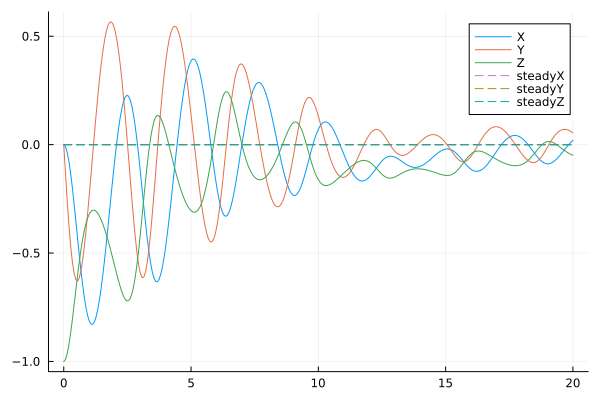

In [3]:
tspan = (0.0, 20.0)
ρ₀ = [1.0+0im 0; 0 0] #Initial condition
γ = 0.1 #Dephasing rate

##Solve ODE
prob = ODEProblem(dρ, ρ₀, tspan, γ)
sol = solve(prob, Tsit5())

#Solve for steady state
ssprob = SteadyStateProblem(dρ, ρ₀, γ)
ssol = solve(ssprob, DynamicSS(Tsit5()), abstol=1e-4)

#Calculate Bloch vectors
ts = range(tspan..., length=300)
bloch_vectors = hcat([2real(QuantumDots.bloch_vector(sol(t), 1, Q)) for t in ts]...) |> transpose
stationary_bloch = 2real(QuantumDots.bloch_vector(ssol.u, 1, Q))

#Plot result
plot(ts, bloch_vectors, label=["X" "Y" "Z"])
plot!([ts[1], ts[end]], hcat(stationary_bloch, stationary_bloch) |> transpose, label="steady" .* ["X" "Y" "Z"], style=:dash)

In [4]:
function plot_bloch(points; res=100)
    φ_range1 = range(0, stop=2 * π, length=res)
    λ_range1 = range(0, stop=π, length=7)
    φ_range2 = range(0, stop=π, length=7)
    λ_range2 = range(0, stop=2π, length=res)
    x1 = [cos(φ) * sin(λ) for φ ∈ φ_range1, λ ∈ λ_range1]
    y1 = [sin(φ) * sin(λ) for φ ∈ φ_range1, λ ∈ λ_range1]
    z1 = [cos(λ) for φ ∈ φ_range1, λ ∈ λ_range1]
    x2 = [cos(φ) * sin(λ) for φ ∈ φ_range2, λ ∈ λ_range2]
    y2 = [sin(φ) * sin(λ) for φ ∈ φ_range2, λ ∈ λ_range2]
    z2 = [cos(λ) for φ ∈ φ_range2, λ ∈ λ_range2]
    sp = plot(xlims=(-1, 1), ylims=(-1, 1), zlims=(-1, 1))
    foreach(n -> plot!(sp, x1[:, n], y1[:, n], z1[:, n], c=:black, legend=:none, alpha = .5), eachindex(eachcol(z1)))
    foreach(n -> plot!(sp, x2[n, :], y2[n, :], z2[n, :], c=:black,  alpha = .5), eachindex(eachrow(z2)))
    ps = range(0,1,20)
    v = points[end,:]
    plot!(sp, eachcol(points)..., linewidth= 3)
    plot!(sp, ps * v[1], ps*v[2], ps*v[3], c=:red, linewidth = 5, seriesalpha = ps)
    return sp
end

plot_bloch (generic function with 1 method)

┌ Info: Saved animation to c:\Users\svens\Projects\QuantumDots.jl\examples\anim_fps15.gif
└ @ Plots C:\Users\svens\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\svens\\Projects\\QuantumDots.jl\\examples\\anim_fps15.gif")
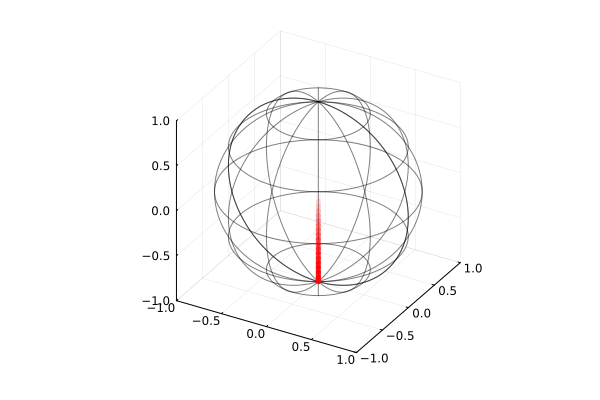

In [5]:
anim = @animate for n ∈ eachindex(eachrow(bloch_vectors))
    points = bloch_vectors[1:n, :]
    plot_bloch(points)
end
gif(anim, "anim_fps15.gif", fps=15)